### Interpreting Machine Learning Models with Counterfactuals

This notebook accompanies the Practical Cheminformatics blog post "[Using Counterfactuals to Understand Machine Learning Models"](https://practicalcheminformatics.blogspot.com/2023/05/using-counterfactuals-to-understand.html). 

To run this notebook you need to first download and gunzip the file replacements02_sc2.5.db.gz from [http://www.qsar4u.com/pages/crem.php](http://www.qsar4u.com/pages/crem.php)

In this notebook we'll build a machine learning model then use counterfactuals to interpret the results of the model. We'll perform the following steps. 
1. Build a classification model to predict aqeous solubility
2. Generate analogs of our target molecule with CrEM
3. Calculate similarity and solubility for the analogs


### Installation
<pre>
pip install rdkit PyTDC useful_rdkit_utils tqdm scikit-learn numpy seaborn exmol pandas mols2grid crem
</pre>

In [20]:
#!pip install useful_rdkit_utils==0.2.7

Lots of imports

In [21]:
from rdkit import Chem, DataStructs
import useful_rdkit_utils as uru
from tqdm.auto import tqdm
from tdc.single_pred import Tox
from sklearn.ensemble import HistGradientBoostingRegressor, HistGradientBoostingClassifier
from sklearn.model_selection import train_test_split
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from sklearn.metrics import r2_score, mean_squared_error, roc_auc_score, matthews_corrcoef
import exmol
import pandas as pd
import mols2grid
from crem.crem import mutate_mol
import requests
from rdkit.Chem import rdFMCS
from rdkit.Chem import AllChem
from rdkit.Chem.Draw import MolsToGridImage

Make the structure images prettier. 

In [22]:
Chem.rdDepictor.SetPreferCoordGen(True) 

### 1. Build a classification model to predict toxic molucules

Enable Pandas progress_apply

In [23]:
tqdm.pandas()

Get solubility data from the [Therapeutic Data Commons](https://tdcommons.ai/)

In [24]:
data = Tox(name = 'ClinTox')

Found local copy...
Loading...
Done!


In [25]:
data.get_data()

,Drug_ID,Drug,Y
0,Drug 0,*C(=O)[C@H](CCCCNC(=O)OCCOC)NC(=O)OCCOC,0
1,Drug 1,Cl[C@H]1[C@H](Cl)[C@@H](Cl)[C@@H](Cl)[C@H](Cl)...,0
2,Drug 2,O=C([O-])[C@@H](O)[C@@H](O)[C@H](O)[C@@H](O)C(...,0
3,Drug 3,[H]/[NH+]=C(\N)C1=CC(=O)/C(=C\C=c2ccc(=C(N)[NH...,0
4,Drug 4,[H]/[NH+]=C(\N)c1ccc(OCCCCCOc2ccc(/C(N)=[NH+]/...,0
...,...,...,...
1473,Drug 1479,O=[Si](O)O,0
1474,Drug 1480,O=[Ti]=O,0
1475,Drug 1481,O=[Zn],0
1476,Drug 1482,[O-][Cl+3]([O-])([O-])O,0


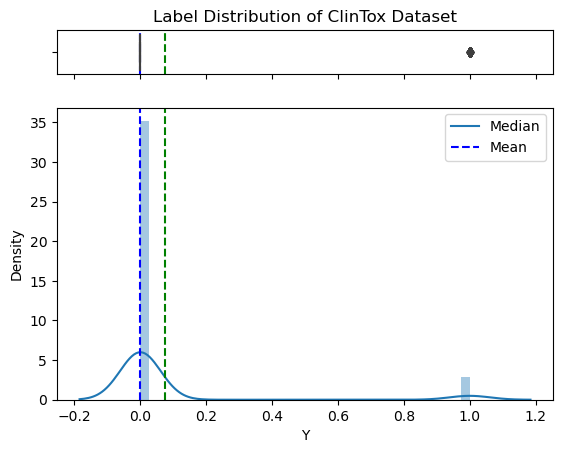

In [26]:
data.label_distribution()

In [27]:
df = data.get_data().copy()
df.columns=['Name','SMILES','Y']

Add an RDKit molecule column to the data

Quickly strip salts.  A call to [RDMolStandardizer](https://www.rdkit.org/docs/source/rdkit.Chem.MolStandardize.rdMolStandardize.html) might be better here. 

In [28]:
df['mol'] = df.SMILES.progress_apply(Chem.MolFromSmiles)

  0%|          | 0/1478 [00:00<?, ?it/s]

In [29]:
df['clean_mol'] = df.mol.progress_apply(uru.get_largest_fragment)

  0%|          | 0/1478 [00:00<?, ?it/s]

Add a fingerprint to the dataframe.  Note that for this exercise, we'll be using two different fingerprints.  A **numpy_fp** will be used for ML models and a **morgan_fp** will be used for calculating similarity. 

In [30]:
df['numpy_fp'] = df.clean_mol.progress_apply(uru.mol2numpy_fp)

  0%|          | 0/1478 [00:00<?, ?it/s]

In [31]:
df['morgan_fp'] = df.clean_mol.progress_apply(uru.mol2morgan_fp)

  0%|          | 0/1478 [00:00<?, ?it/s]

In [32]:
df = df.drop(df[df.Name == "Drug 13"].index[0]).reset_index(drop=True)
df = df.drop(df[df.Name == "Drug 14"].index[0]).reset_index(drop=True)

In [33]:
toxic_mol_to_test = df[df.Y == 1].iloc[1].to_frame().transpose() # chose the 2nd toxic molucule becouse the first toxic was just [SE] and it looked boring to use
df = df.drop(df[df.Y == 1].index[1]).reset_index(drop=True)

Split the data into training and test sets.

In [34]:
train, test = train_test_split(df)

Create a regressor. 

In [35]:
hgbc = HistGradientBoostingClassifier()

In [36]:
hgbc.fit(np.stack(train.numpy_fp),train.Y)

HistGradientBoostingClassifier()

In [37]:
pred = hgbc.predict(np.stack(test.numpy_fp))
pred_df = pd.DataFrame({"Experiment" : test.Y, "Prediction" : pred})

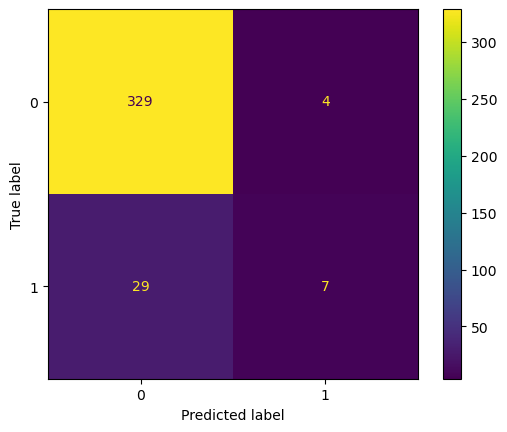

In [38]:
from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
cm = confusion_matrix(pred_df["Experiment"], pred_df["Prediction"])

cm_display = ConfusionMatrixDisplay(cm).plot()
plt.show()

In [39]:
from sklearn.metrics import recall_score, accuracy_score
print(recall_score(pred_df["Experiment"], pred_df["Prediction"], average=None))
print(accuracy_score(pred_df["Experiment"], pred_df["Prediction"]))

[0.98798799 0.19444444]
0.9105691056910569


Toxic Molucole to test

Drug 15


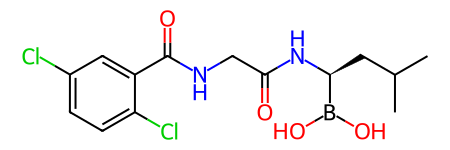

In [40]:
print(toxic_mol_to_test.Name.values[0])
toxic_mol_to_test.mol.values[0]

Predicted incorrectly as not toxic but why?

In [41]:
hgbc.predict(np.stack(toxic_mol_to_test.numpy_fp))

array([0], dtype=int64)

In [42]:
#toxic = df.loc[pred_df.loc[(pred_df["Experiment"] == 1) & (pred_df["Prediction"] == 1)].index.to_list()]
train['sim'] = DataStructs.BulkTanimotoSimilarity(toxic_mol_to_test.morgan_fp.values[0], train.morgan_fp.values)

Almost nothing in the train set is similar to this

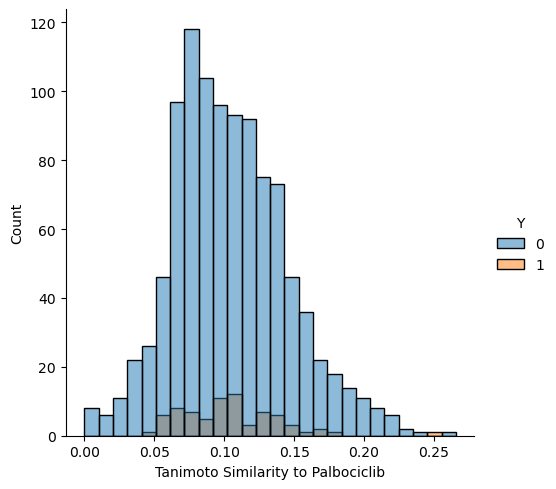

In [43]:
ax = sns.displot(x="sim", data=train, hue="Y")
ax.set(xlabel="Tanimoto Similarity to Palbociclib");

In [44]:
closest = train.sort_values("sim", ascending=False).query("Y == 1").copy()

In [45]:
mols2grid.display(closest.head(5), subset=["Name", "mol", "sim"], transform={"sim": lambda x: f"Similarity {x:.2f}"},
                  selection=False, size=(300,200))

MolGridWidget()